In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import transforms


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!unzip gdrive/My\ Drive/CVAE_data/archive_name.zip

Archive:  gdrive/My Drive/CVAE_data/archive_name.zip
  inflating: contact_maps_traj1.npy  
  inflating: contact_maps_traj2.npy  


In [4]:
# Load the contact maps from files
contact_maps_traj1 = np.load("contact_maps_traj1.npy")
contact_maps_traj2 = np.load("contact_maps_traj2.npy")

In [5]:
print(contact_maps_traj1.shape)
print(contact_maps_traj2.shape)
print(contact_maps_traj1[0].shape)

(10000, 283, 283)
(10000, 283, 283)
(283, 283)


In [6]:
from sklearn.model_selection import train_test_split

# Split the contact maps for each trajectory into train, validation, and test sets
train_maps_traj1, valtest_maps_traj1 = train_test_split(contact_maps_traj1, test_size=0.2, random_state=42)
val_maps_traj1, test_maps_traj1 = train_test_split(valtest_maps_traj1, test_size=0.5, random_state=42)

train_maps_traj2, valtest_maps_traj2 = train_test_split(contact_maps_traj2, test_size=0.2, random_state=42)
val_maps_traj2, test_maps_traj2 = train_test_split(valtest_maps_traj2, test_size=0.5, random_state=42)


In [7]:
# Concatenate and shuffle train maps
train_maps = np.concatenate((train_maps_traj1, train_maps_traj2), axis=0)
np.random.shuffle(train_maps)

# Concatenate and shuffle validation maps
val_maps = np.concatenate((val_maps_traj1, val_maps_traj2), axis=0)
np.random.shuffle(val_maps)

# Concatenate and shuffle test maps
test_maps = np.concatenate((test_maps_traj1, test_maps_traj2), axis=0)
np.random.shuffle(test_maps)


In [8]:
train_data = torch.utils.data.TensorDataset(torch.from_numpy(train_maps).float()) 
val_data = torch.utils.data.TensorDataset(torch.from_numpy(val_maps).float()) 
test_data = torch.utils.data.TensorDataset(torch.from_numpy(test_maps).float())

In [8]:
# Set the batch size
batch_size = 1

In [10]:
train_data = torch.utils.data.TensorDataset(torch.from_numpy(train_maps).float()) 
val_data = torch.utils.data.TensorDataset(torch.from_numpy(val_maps).float()) 
test_data = torch.utils.data.TensorDataset(torch.from_numpy(test_maps).float())
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True) 
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True) 
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [14]:
import torch.optim as optim

def conv_output_size(input_size, kernel_size, stride=1, padding=0):
    return (input_size - kernel_size + 2 * padding) // stride + 1

input_size = 283
conv1_out = conv_output_size(input_size, kernel_size=4, stride=1)
conv2_out = conv_output_size(conv1_out, kernel_size=4, stride=1)
conv3_out = conv_output_size(conv2_out, kernel_size=4, stride=1)
print("Output size after Conv1:", conv1_out)
print("Output size after Conv2:", conv2_out)
print("Output size after Conv3:", conv3_out)

class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()
        self.latent_dim = 20
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(8, 8, kernel_size=3, stride=1)

        self.fc1 = nn.Linear(8 * 277 * 277, 256)
        self.fc21 = nn.Linear(256, 64)
        self.fc22 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 8 * 276 * 276)
        self.fc4 = nn.Linear(256, 8 * 276 * 276)

        self.deconv1 = nn.ConvTranspose2d(8, 8, kernel_size=3, stride=1)
        self.deconv2 = nn.ConvTranspose2d(8, 4, kernel_size=3, stride=1)
        self.deconv3 = nn.ConvTranspose2d(4, 1, kernel_size=3, stride=1)

    def encode(self, x):
        h1 = F.relu(self.conv1(x))
        h2 = F.relu(self.conv2(h1))
        h3 = F.relu(self.conv3(h2))
        #print("h3 shape:", h3.shape)
        h3 = h3.view(-1, 8 * 277 * 277)  # Update dimensions here
        h4 = F.relu(self.fc1(h3))
        return self.fc21(h4), self.fc22(h4)


    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
      h3 = F.relu(self.fc3(z))
      h3 = h3.view(-1, 8, 276, 276)
      h2 = F.relu(self.deconv1(h3))
      h1 = F.relu(self.deconv2(h2))
      out = torch.sigmoid(self.deconv3(h1))

    # Add padding to match input size
      out_padded = F.pad(out, (1, 0, 1, 0))
      return out_padded


    def forward(self, x):
      mu, logvar = self.encode(x)
      z = self.reparameterize(mu, logvar)
      return self.decode(z), mu, logvar


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
best_val_loss = float('inf')
def train(epoch, train_dataloader):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_dataloader):
        data = data[0].to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        
        # Squeeze the output tensor to remove the extra dimension
        recon_batch = recon_batch.squeeze(dim=1)
        
        recon_loss = nn.BCELoss()(recon_batch, data)
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + kl_loss
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_dataloader.dataset):.4f}')

# 4. Write the evaluation code
def validate(epoch, val_dataloader):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in val_dataloader:
            data = data[0].to(device)
            recon_batch, mu, logvar = model(data)
            recon_batch = recon_batch.squeeze(1)
            recon_loss = nn.BCELoss()(recon_batch, data)
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            kl_loss /= data.shape[0] * 283 * 283
            loss = recon_loss + kl_loss
            val_loss += loss.item()

    val_loss /= len(val_dataloader.dataset)
    print('====> Validation set loss: {:.4f}'.format(val_loss))
    return val_loss

# Test the model
def test(test_dataloader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data in test_dataloader:
            data = data[0].to(device)
            recon_batch, mu, logvar = model(data)
            recon_batch = recon_batch.squeeze(1)
            z = model.reparameterize(mu, logvar)
            recon_loss = nn.BCELoss()(recon_batch, data)
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            kl_loss /= data.shape[0] * 283 * 283
            loss = recon_loss + kl_loss
            test_loss += loss.item()

    test_loss /= len(test_dataloader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')


Output size after Conv1: 280
Output size after Conv2: 277
Output size after Conv3: 274


In [15]:
# Train and validate the model
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train(epoch, train_dataloader)
    val_loss = validate(epoch, val_dataloader)

    # Check if the current validation loss is better than the best validation loss
    if val_loss < best_val_loss:
        # Update the best validation loss
        best_val_loss = val_loss
        # Save the model
        torch.save(model.state_dict(), 'best_model.pth')

====> Epoch: 1 Average loss: 18665735.7799
====> Validation set loss: 0.0167
====> Epoch: 2 Average loss: 0.1829
====> Validation set loss: 0.0161
====> Epoch: 3 Average loss: 0.0822
====> Validation set loss: 0.0159
====> Epoch: 4 Average loss: 0.0159
====> Validation set loss: 0.0158
====> Epoch: 5 Average loss: 0.0158
====> Validation set loss: 0.0158
====> Epoch: 6 Average loss: 0.0158
====> Validation set loss: 0.0158
====> Epoch: 7 Average loss: 0.0158
====> Validation set loss: 0.0158
====> Epoch: 8 Average loss: 0.0158
====> Validation set loss: 0.0157
====> Epoch: 9 Average loss: 0.0157
====> Validation set loss: 0.0158
====> Epoch: 10 Average loss: 0.0157
====> Validation set loss: 0.0157


<ipython-input-22-0ab7af357470>:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(pca_latent_vars[:, 0], pca_latent_vars[:, 1], cmap='inferno')


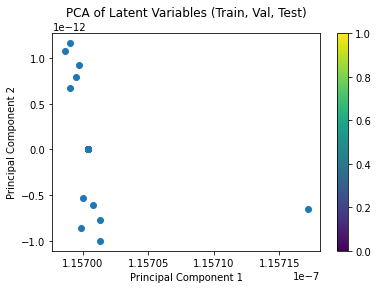

In [22]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def extract_latent_variables(dataloader):
    model.eval()
    latents = []
    with torch.no_grad():
        for data in dataloader:
            data = data[0].to(device)
            mu, _ = model.encode(data)
            latents.append(mu.cpu().numpy())
    return np.vstack(latents)

train_latent_vars = extract_latent_variables(train_dataloader)
val_latent_vars = extract_latent_variables(val_dataloader)
test_latent_vars = extract_latent_variables(test_dataloader)

# Concatenate train, validation, and test latent variables
all_latent_vars = np.concatenate([train_latent_vars, val_latent_vars, test_latent_vars], axis=0)

# Perform PCA
pca = PCA(n_components=2)
pca_latent_vars = pca.fit_transform(all_latent_vars)

# Create a scatter plot using the inferno colormap
plt.scatter(pca_latent_vars[:, 0], pca_latent_vars[:, 1], cmap='inferno')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Latent Variables (Train, Val, Test)')
plt.colorbar()
plt.show()


In [25]:
# Find the top N contacts for each principal component
N = 10  # Number of top contacts to identify
top_pc1_contacts = np.argsort(np.abs(pc1))[-N:]
top_pc2_contacts = np.argsort(np.abs(pc2))[-N:]

print("Top", N, "contacts for PC1:", top_pc1_contacts)
print("Top", N, "contacts for PC2:", top_pc2_contacts)


Top 10 contacts for PC1: [18 20 50 36 57 53 32 26 35 61]
Top 10 contacts for PC2: [19 31 36 57 18 53 32 26 35 61]
